In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot')
import dateutil.parser
import re
import time

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
datestring = time.strftime("%m-%h-%d")
datestring

'07-Jul-17'

# Functions for Scraper

In [2]:
#Function to pick every other player (because of duplicates):
def removing_every_other_player(x):
    return x[::2]

In [3]:
#Functions for visiting players profil page:
def alter(player):
    try:
        return player.find('th', text = re.compile('Alter:')).findNext('td').string
    except:
        return None

In [4]:
def im_team_seit(player):
    try:
        return player.find('th', text = re.compile('Im Team seit:')).findNext('td').string.strip()
    except:
        return None

In [5]:
def position(player):
    if player == None:
        return None
    else:
        return player.find('th', text = re.compile('Position:'))\
    .findNext('td').string.strip()

In [19]:
def groesse(player):
    try:
        return int(player.find('th', text = re.compile('Größe:')).findNext('td').string.replace(',', '').replace(' m', ''))
    except:
        return None

In [6]:
def club(player):
    if player.find('th', text = re.compile('Aktueller Verein:')).string.strip() == 'Aktueller Verein:':
        return player.find('th', text = re.compile('Aktueller')).findNext('td').findNext('a').find('img').get('alt')
    elif player.find('th', text = re.compile('Current club:')).string.strip() == 'Current club:':
        return player.find('th', text = re.compile('Current club:')).findNext('td').findNext('a').find('img').get('alt')
    else:
        return

In [7]:
#Function to extract the former club:
def ex_club(player):
    try:
        return player.find('td', {'class': 'hauptlink no-border-links hide-for-small vereinsname'}).findNext('a').string
    except:
        return None

In [8]:
def agent(player):
    try:
        return player.find('th', text = re.compile("Spielerberater:"))\
    .findNext('td').findNext('a').get('title')
    except:
        return None

In [12]:
def marktwert(player):
    try:
        return player.find('div', {'class': 'right-td'}).findNext('a').text.replace(',', '').replace(' Mio. €', '0000').replace(' Tsd. €', '0000')
    except:
        return None

In [9]:
def shoes(player):
    try:
        return player.find('th', text = re.compile("Ausrüster:")).findNext('td')\
    .findNext('a').findNext('img').get('title')
    except:
        return None

In [10]:
def ausgeliehen_von(player):
    try:
        return player.find('th', text = re.compile("Ausgeliehen von:")).findNext('td').find('a').text
    except:
        return None

In [11]:
def Minuten(x):
    try:
        return int(x.find('td', {'class': 'zentriert'}).find_next('td', {'class': 'rechts'}).string.replace("'", ''))
    except:
        return None

# Scraping

In [13]:
#This site doesn't like to be scraped, therefore I'll use this header:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

In [21]:
#url = "http://www.transfermarkt.com/raiffeisen-super-league/transfers/wettbewerb/C1/saison_id/2017"
url = "http://www.transfermarkt.ch/raiffeisen-super-league/transfers/wettbewerb/C1/saison_id/2017"
response = requests.get(url, headers=headers)
transfermarkt_soup = BeautifulSoup(response.text, 'html.parser')

In [22]:
transfermarkt = transfermarkt_soup.find_all('a', {'class': 'spielprofil_tooltip'})

In [23]:
#not what that does - have to check again.
transfermarkt.pop(0)
#Only picking every other player
transfermarkt = removing_every_other_player(transfermarkt)

In [24]:
transfer_dict = []

for spieler in transfermarkt:
    
    #Name
    Name = spieler.string
    print(Name)
    
    #Link
    spieler_link = spieler['href']
    spieler_link = 'http://www.transfermarkt.ch' + spieler_link
    #print(spieler_link)
    
    #Visiting players profil pages
    spieler_profil = requests.get(spieler_link, headers=headers)
    spieler_profil = BeautifulSoup(spieler_profil.text, 'html.parser')
    #print(spieler_profil)
    
    Alter = alter(spieler_profil)
    #print(Alter)
    Grösse = groesse(spieler_profil)
    #print(Grösse)
    Position = position(spieler_profil)
    #print(Position)
    Verein = club(spieler_profil)
    #print(Verein)
    Ex_Verein = ex_club(spieler_profil)
    #print(Ex_Verein)
    Agent = agent(spieler_profil)
    #print(Agent)
    Ausrüster = shoes(spieler_profil)
    #print(Ausrüster)
    Im_team_seit = im_team_seit(spieler_profil)
    #print(Im_team_seit)
    Marktwert = marktwert(spieler_profil)
    Ausgeliehen_von = ausgeliehen_von(spieler_profil)
    #print(Marktwert)

    #Visiting Leistungsdaten pages
    spieler_leistungsdaten_link = spieler_link.replace('profil', 'leistungsdaten')
    spieler_leistungsdaten_link = spieler_leistungsdaten_link + '/plus/0?saison=ges'
    spieler_leistungsdaten = requests.get(spieler_leistungsdaten_link, headers=headers)
    spieler_leistungsdaten = BeautifulSoup(spieler_leistungsdaten.text, 'html.parser')
    print(spieler_leistungsdaten_link)
    
    #This is possible to do in a list because every player has these parameters
    Spiele = spieler_leistungsdaten.find('tfoot')
    leistungsdaten = Spiele.find_all('td', {'class': 'zentriert'})
    leistungsdaten_list = []
    for Daten in leistungsdaten:
        Daten = Daten.string
        leistungsdaten_list.append(Daten)
    
    if len(leistungsdaten_list) > 6:
        Totalspiele = int(leistungsdaten_list[0].replace('-', '0'))
        Tore = int(leistungsdaten_list[1].replace('-', '0'))
        Vorlagen = 0
        Gelbe_Karten = int(leistungsdaten_list[2].replace('-', '0'))
        Gelb_Rote_Karten = int(leistungsdaten_list[3].replace('-', '0'))
        Rote_Karten = int(leistungsdaten_list[4].replace('-', '0'))
    
    else:
        Totalspiele = int(leistungsdaten_list[0].replace('-', '0'))
        Tore = int(leistungsdaten_list[1].replace('-', '0'))
        Vorlagen = int(leistungsdaten_list[2].replace('-', '0'))
        Gelbe_Karten = int(leistungsdaten_list[3].replace('-', '0'))
        Gelb_Rote_Karten = int(leistungsdaten_list[4].replace('-', '0'))
        Rote_Karten = int(leistungsdaten_list[5].replace('-', '0'))
        #print(leistungsdaten_list)
        
#Minuten = Minuten(Spiele)
    
    Spieler_Dict = {"Name": Name,
                    "Alter": Alter,
                    "URL": spieler_link,
                    "Grösse": Grösse,
                    "Position": Position,
                    "Verein": Verein,
                    "Wechsel von": Ex_Verein,
                    "Ausgeliehen von": Ausgeliehen_von,
                    "Agent": Agent,
                    "Ausrüster": Ausrüster,
                    "Im Team seit": Im_team_seit,
                    "Total Spiele": Totalspiele,
                    "Tore": Tore,
                    "Vorlagen": Vorlagen,
                    "Gelbe Karten": Gelbe_Karten,
                    "Gelb-Rote Karten": Gelb_Rote_Karten,
                    "Rote Karten": Rote_Karten,
                    'Marktwert': Marktwert,
                    'Minuten': Minuten
                    }
    
    transfer_dict.append(Spieler_Dict)

R. van Wolfswinkel
http://www.transfermarkt.ch/ricky-van-wolfswinkel/leistungsdaten/spieler/41355/plus/0?saison=ges
F. Frei
http://www.transfermarkt.ch/fabian-frei/leistungsdaten/spieler/52595/plus/0?saison=ges
A. Ajeti
http://www.transfermarkt.ch/albian-ajeti/leistungsdaten/spieler/195906/plus/0?saison=ges
D. Oberlin
http://www.transfermarkt.ch/dimitri-oberlin/leistungsdaten/spieler/212718/plus/0?saison=ges
V. Stocker
http://www.transfermarkt.ch/valentin-stocker/leistungsdaten/spieler/45178/plus/0?saison=ges
L. Lacroix
http://www.transfermarkt.ch/leo-lacroix/leistungsdaten/spieler/149652/plus/0?saison=ges
S. Campo
http://www.transfermarkt.ch/samuele-campo/leistungsdaten/spieler/183446/plus/0?saison=ges
D. Nikolic
http://www.transfermarkt.ch/djordje-nikolic/leistungsdaten/spieler/274344/plus/0?saison=ges
S. Antonio
http://www.transfermarkt.ch/signori-antonio/leistungsdaten/spieler/147029/plus/0?saison=ges
N. Okafor
http://www.transfermarkt.ch/noah-okafor/leistungsdaten/spieler/346890/p

http://www.transfermarkt.ch/noah-loosli/leistungsdaten/spieler/265209/plus/0?saison=ges
P. Olsen
http://www.transfermarkt.ch/patrick-olsen/leistungsdaten/spieler/135217/plus/0?saison=ges
N. Bahoui
http://www.transfermarkt.ch/nabil-bahoui/leistungsdaten/spieler/93184/plus/0?saison=ges
N. Hunziker
http://www.transfermarkt.ch/nicolas-hunziker/leistungsdaten/spieler/184193/plus/0?saison=ges
M. Dabbur
http://www.transfermarkt.ch/munas-dabbur/leistungsdaten/spieler/145866/plus/0?saison=ges
G. Chande
http://www.transfermarkt.ch/gion-chande/leistungsdaten/spieler/290013/plus/0?saison=ges
S. Rapp
http://www.transfermarkt.ch/simone-rapp/leistungsdaten/spieler/154635/plus/0?saison=ges
F. Margiotta
http://www.transfermarkt.ch/francesco-margiotta/leistungsdaten/spieler/165891/plus/0?saison=ges
D. Mesbah
http://www.transfermarkt.ch/djamel-mesbah/leistungsdaten/spieler/17735/plus/0?saison=ges
E. Zidane
http://www.transfermarkt.ch/enzo-zidane/leistungsdaten/spieler/106825/plus/0?saison=ges
V. Bojinov


http://www.transfermarkt.ch/radomir-milosavljevic/leistungsdaten/spieler/145339/plus/0?saison=ges
D. Kovacic
http://www.transfermarkt.ch/dominik-kovacic/leistungsdaten/spieler/258898/plus/0?saison=ges
K. Rossi
http://www.transfermarkt.ch/karim-rossi/leistungsdaten/spieler/183152/plus/0?saison=ges
G. Franzese
http://www.transfermarkt.ch/gioele-franzese/leistungsdaten/spieler/413460/plus/0?saison=ges
O. Urbano
http://www.transfermarkt.ch/orlando-urbano/leistungsdaten/spieler/39687/plus/0?saison=ges
A. Rey
http://www.transfermarkt.ch/antoine-rey/leistungsdaten/spieler/33056/plus/0?saison=ges
A. Culina
http://www.transfermarkt.ch/antonini-culina/leistungsdaten/spieler/95745/plus/0?saison=ges
O. Mizrahi
http://www.transfermarkt.ch/ofir-mizrahi/leistungsdaten/spieler/252875/plus/0?saison=ges
E. Abedini
http://www.transfermarkt.ch/eris-abedini/leistungsdaten/spieler/413459/plus/0?saison=ges
G. Franzese
http://www.transfermarkt.ch/gioele-franzese/leistungsdaten/spieler/413460/plus/0?saison=ges

http://www.transfermarkt.ch/andre-neitzke/leistungsdaten/spieler/164646/plus/0?saison=ges
A. Grgic
http://www.transfermarkt.ch/anto-grgic/leistungsdaten/spieler/192637/plus/0?saison=ges
C. Zock
http://www.transfermarkt.ch/christian-zock/leistungsdaten/spieler/337017/plus/0?saison=ges
M. Cunha
http://www.transfermarkt.ch/matheus-cunha/leistungsdaten/spieler/517894/plus/0?saison=ges
E. Cümart
http://www.transfermarkt.ch/eray-cumart/leistungsdaten/spieler/298583/plus/0?saison=ges
P. Ramírez
http://www.transfermarkt.ch/pedro-ramirez/leistungsdaten/spieler/308812/plus/0?saison=ges
A. Pinga
http://www.transfermarkt.ch/aimery-pinga/leistungsdaten/spieler/347097/plus/0?saison=ges
J. Adão
http://www.transfermarkt.ch/joaquim-adao/leistungsdaten/spieler/122205/plus/0?saison=ges
Y. Hofer
http://www.transfermarkt.ch/yanick-hofer/leistungsdaten/spieler/298592/plus/0?saison=ges
J. Castanheira
http://www.transfermarkt.ch/joao-castanheira/leistungsdaten/spieler/287490/plus/0?saison=ges
I. Mboyo
http://

http://www.transfermarkt.ch/colin-trachsel/leistungsdaten/spieler/341324/plus/0?saison=ges
S. Schäppi
http://www.transfermarkt.ch/silvano-schappi/leistungsdaten/spieler/147055/plus/0?saison=ges
G. Frontino
http://www.transfermarkt.ch/gianluca-frontino/leistungsdaten/spieler/59036/plus/0?saison=ges
S. Rapp
http://www.transfermarkt.ch/simone-rapp/leistungsdaten/spieler/154635/plus/0?saison=ges
E. Schirinzi
http://www.transfermarkt.ch/enrico-schirinzi/leistungsdaten/spieler/33348/plus/0?saison=ges
L. Zino
http://www.transfermarkt.ch/lotem-zino/leistungsdaten/spieler/201169/plus/0?saison=ges
N. Schindelholz
http://www.transfermarkt.ch/nicolas-schindelholz/leistungsdaten/spieler/65287/plus/0?saison=ges
G. Frontino
http://www.transfermarkt.ch/gianluca-frontino/leistungsdaten/spieler/59036/plus/0?saison=ges
J. Geissmann
http://www.transfermarkt.ch/joel-geissmann/leistungsdaten/spieler/167188/plus/0?saison=ges
N. Peyretti
http://www.transfermarkt.ch/norman-peyretti/leistungsdaten/spieler/27836

http://www.transfermarkt.ch/kilian-pagliuca/leistungsdaten/spieler/192652/plus/0?saison=ges
Y. Fillion
http://www.transfermarkt.ch/yann-alexandre-fillion/leistungsdaten/spieler/364653/plus/0?saison=ges
D. Chiumiento
http://www.transfermarkt.ch/davide-chiumiento/leistungsdaten/spieler/17332/plus/0?saison=ges
G. Yapi
http://www.transfermarkt.ch/gilles-yapi/leistungsdaten/spieler/13105/plus/0?saison=ges
N. Baumann
http://www.transfermarkt.ch/novem-baumann/leistungsdaten/spieler/183308/plus/0?saison=ges
A. Sadrijaj
http://www.transfermarkt.ch/albin-sadrijaj/leistungsdaten/spieler/258289/plus/0?saison=ges
A. Favre
http://www.transfermarkt.ch/anthony-favre/leistungsdaten/spieler/10059/plus/0?saison=ges
M. Muheim
http://www.transfermarkt.ch/miro-muheim/leistungsdaten/spieler/298603/plus/0?saison=ges


# Making a Dataframe and cleaning it

In [25]:
#Making the DataFrame
df_transfers = pd.DataFrame(transfer_dict)

In [26]:
df_transfers.head()

,Agent,Alter,Ausgeliehen von,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,Position,Rote Karten,Tore,Total Spiele,URL,Verein,Vorlagen,Wechsel von
0,Louis Laros,29,None,None,1,37,None,01.07.2017,3000000,<function Minuten at 0x1153ad950>,R. van Wolfswinkel,Sturm - Mittelstürmer,0,138,354,http://www.transfermarkt.ch/ricky-van-wolfswin...,FC Basel 1893,28,Vitesse Arnheim
1,Giallanza Sport,29,None,,0,50,None,01.01.2018,2250000,<function Minuten at 0x1153ad950>,F. Frei,Mittelfeld - Defensives Mittelfeld,1,73,457,http://www.transfermarkt.ch/fabian-frei/profil...,FC Basel 1893,62,1.FSV Mainz 05
2,ESHA,21,None,Nike Nike Mercurial Superfly 360,0,17,None,02.10.2017,5000000,<function Minuten at 0x1153ad950>,A. Ajeti,Sturm - Mittelstürmer,0,64,172,http://www.transfermarkt.ch/albian-ajeti/profi...,FC Basel 1893,16,FC St. Gallen
3,SOCCER MONDIAL,20,None,Nike Nike Hypervenom Phantom III,0,11,None,01.07.2018,6000000,<function Minuten at 0x1153ad950>,D. Oberlin,Sturm - Mittelstürmer,1,44,130,http://www.transfermarkt.ch/dimitri-oberlin/pr...,FC Basel 1893,14,RB Salzburg
4,IFM,29,None,Nike Nike Magista Obra II,1,64,None,10.01.2018,1500000,<function Minuten at 0x1153ad950>,V. Stocker,Mittelfeld - Offensives Mittelfeld,2,96,407,http://www.transfermarkt.ch/valentin-stocker/p...,FC Basel 1893,100,Hertha BSC


In [27]:
df_transfers.shape

(414, 19)

In [29]:
#Test for one club:
df_transfers[df_transfers['Verein'] == 'BSC Young Boys'].head()

,Agent,Alter,Ausgeliehen von,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,Position,Rote Karten,Tore,Total Spiele,URL,Verein,Vorlagen,Wechsel von
123,None,19,None,Nike Nike Magista Obra II,0,6,None,01.07.2017,4500000,<function Minuten at 0x1153ad950>,J. Lotomba,Abwehr - Rechter Verteidiger,0,10,116,http://www.transfermarkt.ch/jordan-lotomba/pro...,BSC Young Boys,7,Lausanne-Sport
336,Sport 11 AG,24,None,Nike Nike Mercurial Superfly 360,0,27,None,01.07.2017,4000000,<function Minuten at 0x1153ad950>,C. Fassnacht,Sturm - Rechtsaußen,0,70,233,http://www.transfermarkt.ch/christian-fassnach...,BSC Young Boys,19,FC Thun
341,TJP-Sport-Management,24,None,,1,10,None,26.08.2017,2500000,<function Minuten at 0x1153ad950>,N. Moumi Ngamaleu,Sturm - Rechtsaußen,0,15,84,http://www.transfermarkt.ch/nicolas-moumi-ngam...,BSC Young Boys,11,SCR Altach
342,Signature - ISCM AG,21,None,Nike Nike Magista Obra II,0,12,None,01.07.2017,6500000,<function Minuten at 0x1153ad950>,D. Sow,Mittelfeld - Zentrales Mittelfeld,0,10,115,http://www.transfermarkt.ch/djibril-sow/profil...,BSC Young Boys,14,Bor. M'gladbach
343,Sport Profile,25,None,None,0,8,None,19.07.2017,4500000,<function Minuten at 0x1153ad950>,J. Nsame,Sturm - Mittelstürmer,0,40,105,http://www.transfermarkt.ch/jean-pierre-nsame/...,BSC Young Boys,12,Servette FC


In [30]:
#Dealing with the loan of players:
#1.) Sorting out only the loaned players. Moving column to the back. 
#2.) Deleting last club column. Renaming the loaned column. 
#3.) Concating it with the original file.
#So now the last club column is correct. 
df_ausgeliehen = df_transfers[df_transfers['Ausgeliehen von'].notnull()]

def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

#moving column to the back
df = change_column_order(df_ausgeliehen, 'Ausgeliehen von', 17)

del df['Wechsel von']

#Renaming last column
df.columns = df.columns.str.replace('Ausgeliehen von','Wechsel von')

#Prepping original dataframe
df_transfers = df_transfers[df_transfers['Ausgeliehen von'].isnull()]

del df_transfers['Ausgeliehen von']

#concating the two
df_SL_transfers = pd.concat([df, df_transfers], ignore_index=True)

#Dropping any duplicate values
df_SL_transfers = df_SL_transfers.drop_duplicates()

In [31]:
# Making sure all the clubs are spelt correctly:

#Dealing with the name problem of the Clubs (FCB, Grasshoppers etc.). Two different names for FCB, Lausanne, GC, FCSG in the columns.
def fcb_lausanne(x):
    return x.replace(' 1893', '').replace('Grasshoppers', 'Grasshopper Club Zürich').replace('Lausanne-Sport', 'FC Lausanne-Sport').replace('FC St. Gallen', 'FC St. Gallen 1879')

def fcb(x):
    return x.replace(' 1893', '')

df_SL_transfers['*Wechsel von*'] = df_SL_transfers['Wechsel von'].apply(fcb_lausanne)
df_SL_transfers['*Verein*'] = df_SL_transfers['Verein'].apply(fcb)

In [32]:
df_SL_transfers.head()

,Agent,Alter,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,Position,Rote Karten,Tore,Total Spiele,URL,Verein,Vorlagen,Wechsel von,*Wechsel von*,*Verein*
0,Footuro AG,21,Nike Nike Magista Obra II,0,3,None,11.01.2018,6000000,<function Minuten at 0x1153ad950>,D. Nikolic,Torwart,0,0,45,http://www.transfermarkt.ch/djordje-nikolic/pr...,FC Thun,0,FC Basel 1893,FC Basel,FC Thun
1,ESHA,20,None,0,6,None,15.01.2018,5000000,<function Minuten at 0x1153ad950>,D. Schmid,Mittelfeld - Offensives Mittelfeld,0,11,84,http://www.transfermarkt.ch/dominik-schmid/pro...,FC Lausanne-Sport,1,FC Basel 1893,FC Basel,FC Lausanne-Sport
2,Sportfront GmbH,24,Nike Nike Magista Obra II,0,6,None,05.07.2018,6500000,<function Minuten at 0x1153ad950>,M. Salvi,Torwart,0,0,150,http://www.transfermarkt.ch/mirko-salvi/profil...,FC Luzern,0,Grasshopper Club Zürich,Grasshopper Club Zürich,FC Luzern
6,Gol de Classe,21,None,0,25,None,26.02.2018,3000000,<function Minuten at 0x1153ad950>,P. Pacheco,Abwehr - Innenverteidiger,1,3,90,http://www.transfermarkt.ch/pedro-pacheco/prof...,FC Rapperswil-Jona,1,FC Basel 1893,FC Basel,FC Rapperswil-Jona
7,Sportfront GmbH,23,None,0,13,None,22.06.2018,5000000,<function Minuten at 0x1153ad950>,R. Kapic,Mittelfeld - Zentrales Mittelfeld,0,18,84,http://www.transfermarkt.ch/rifet-kapic/profil...,Sheriff Tiraspol,5,Grasshopper Club Zürich,Grasshopper Club Zürich,Sheriff Tiraspol


In [52]:
#Checking the dtypes:
df_SL_transfers.dtypes

Agent               object
Alter               object
Ausrüster           object
Gelb-Rote Karten     int64
Gelbe Karten         int64
Grösse              object
Im Team seit        object
Marktwert           object
Minuten             object
Name                object
Position            object
Rote Karten          int64
Tore                 int64
Total Spiele         int64
URL                 object
Verein              object
Vorlagen             int64
Wechsel von         object
*Wechsel von*       object
*Verein*            object
dtype: object

In [55]:
#Changing the datype of Marktwert to an float, but some '-' and ' ' that cause problems when trying to convert:
df_SL_transfers['Marktwert'].replace(['-', ' '], ['NaN', 'NaN'], inplace=True)

In [57]:
#Test:
df_SL_transfers['Marktwert'].head()

0    6000000
1    5000000
2    6500000
6    3000000
7    5000000
Name: Marktwert, dtype: object

In [59]:
df_SL_transfers['Marktwert'] = df_SL_transfers.Marktwert.astype(float)

In [78]:
df_SL_transfers.dtypes

Agent                object
Alter                object
Ausrüster            object
Gelb-Rote Karten      int64
Gelbe Karten          int64
Grösse               object
Im Team seit         object
Marktwert           float64
Minuten              object
Name                 object
Position             object
Rote Karten           int64
Tore                  int64
Total Spiele          int64
URL                  object
Verein               object
Vorlagen              int64
Wechsel von          object
*Wechsel von*        object
*Verein*             object
dtype: object

In [120]:
#Safeing dataframe:
df_SL_transfers.to_csv('SL_transfers.csv', index=False)

## Analyzing the data 

In [34]:
#Shoes:
df_SL_transfers['Ausrüster'].value_counts()

                                    43
Nike Nike Mercurial Superfly 360    20
Nike Nike Mercurial Vapor 360       17
Nike Nike Magista Obra II           16
Nike Nike Hypervenom Phantom III    13
Nike Nike Tiempo Legend VII FG       7
Vereinslos                           2
Name: Ausrüster, dtype: int64

In [39]:
#Top 10 most active agents in Switzerland:
df_SL_transfers['Agent'].value_counts().head(10)

SOCCER MONDIAL        15
IFM                   14
ohne Berater          12
Familienangehörige    10
Sportfront GmbH        9
Footuro AG             7
Giallanza Sport        6
ESHA                   6
SBE Management AG      5
Soccerdome             4
Name: Agent, dtype: int64

In [51]:
#Biggest player agency:
soccer_mondial = df_SL_transfers[df_SL_transfers. Agent == 'SOCCER MONDIAL']
soccer_mondial.head()

,Agent,Alter,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,Position,Rote Karten,Tore,Total Spiele,URL,Verein,Vorlagen,Wechsel von,*Wechsel von*,*Verein*
18,SOCCER MONDIAL,21,Nike Nike Magista Obra II,2,9,None,11.01.2018,2250000,<function Minuten at 0x1153ad950>,A. Grgic,Mittelfeld - Zentrales Mittelfeld,0,9,114,http://www.transfermarkt.ch/anto-grgic/profil/...,FC Sion,10,VfB Stuttgart,VfB Stuttgart,FC Sion
38,SOCCER MONDIAL,20,Nike Nike Hypervenom Phantom III,0,11,None,01.07.2018,6000000,<function Minuten at 0x1153ad950>,D. Oberlin,Sturm - Mittelstürmer,1,44,130,http://www.transfermarkt.ch/dimitri-oberlin/pr...,FC Basel 1893,14,RB Salzburg,RB Salzburg,FC Basel
49,SOCCER MONDIAL,21,Nike Nike Mercurial Vapor 360,1,23,None,01.07.2017,5000000,<function Minuten at 0x1153ad950>,N. Manzambi,Sturm - Mittelstürmer,0,43,124,http://www.transfermarkt.ch/neftali-manzambi/p...,FC Basel 1893,6,FC Basel U21,FC Basel U21,FC Basel
73,SOCCER MONDIAL,24,None,1,19,None,01.07.2018,4000000,<function Minuten at 0x1153ad950>,A. Avdijaj,Sturm - Mittelstürmer,0,72,188,http://www.transfermarkt.ch/albion-avdijaj/pro...,Vereinslos,20,Grasshoppers,Grasshopper Club Zürich,Vereinslos
87,SOCCER MONDIAL,20,Nike Nike Mercurial Superfly 360,0,10,None,29.01.2018,5000000,<function Minuten at 0x1153ad950>,N. Sukacev,Sturm - Rechtsaußen,1,7,58,http://www.transfermarkt.ch/nikola-sukacev/pro...,Grasshopper Club Zürich,2,GC Zürich U21,GC Zürich U21,Grasshopper Club Zürich


In [64]:
#Players with Soccer Mondial:
soccer_mondial.Name

18         A. Grgic
38       D. Oberlin
49      N. Manzambi
73       A. Avdijaj
87       N. Sukacev
92     H. Tabakovic
99        J. Bamert
112       M. Dabbur
242    M. Schneuwly
255        M. Angha
275    N. Lüchinger
278      V. Salatic
339    E. Schirinzi
350        M. Bürki
391     T. Schättin
Name: Name, dtype: object

In [62]:
#Number of players with Soccer Mondial:
soccer_mondial.Name.count()

15

In [77]:
#Market value of players with Soccer Mondial:
soccer_mondial.groupby('Name').Marktwert.value_counts()

Name          Marktwert
A. Avdijaj    4000000      1
A. Grgic      2250000      1
D. Oberlin    6000000      1
E. Schirinzi  2750000      1
H. Tabakovic  3500000      1
J. Bamert     1100000      1
M. Angha      7000000      1
M. Bürki      4000000      1
M. Dabbur                  1
M. Schneuwly  6000000      1
N. Lüchinger  7500000      1
N. Manzambi   5000000      1
N. Sukacev    5000000      1
T. Schättin   5500000      1
V. Salatic    8000000      1
Name: Marktwert, dtype: int64

In [ ]:
#How can I sum all the market values of the players from Soccer mondial?

# Creating Dataframes to establish gain, losses of each club

In [168]:
#Importing Super League Clubs
df_SL_Vereine = pd.read_csv("Super_League_Vereine_18_19.csv")

In [169]:
df_SL_Vereine.head(10)

,SL-Verein,Group 1,Group 2
0,FC Basel,FCB,FCB
1,FC Sion,Sion,Rest
2,FC Lugano,Lugano,Rest
3,FC Lausanne-Sport,Rest,Rest
4,BSC Young Boys,Rest,Rest
5,Grasshopper Club Zürich,Rest,Rest
6,FC Luzern,Rest,Rest
7,FC Zürich,Rest,Rest
8,FC St. Gallen 1879,Rest,Rest
9,FC Thun,Rest,Rest


In [170]:
#Merging the Files
df_SL_Zuzuege = df_SL_transfers.merge(df_SL_Vereine, left_on = '*Verein*', right_on ='SL-Verein') 
df_SL_Abgaenge = df_SL_transfers.merge(df_SL_Vereine, left_on = '*Wechsel von*', right_on ='SL-Verein')

In [174]:
#Having a look:
df_SL_Zuzuege.head()

,Agent,Alter,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,...,Total Spiele,URL,Verein,Vorlagen,Wechsel von,*Wechsel von*,*Verein*,SL-Verein,Group 1,Group 2
0,Footuro AG,21,Nike Nike Magista Obra II,0,3,None,11.01.2018,6000000.0,<function Minuten at 0x1153ad950>,D. Nikolic,...,45,http://www.transfermarkt.ch/djordje-nikolic/pr...,FC Thun,0,FC Basel 1893,FC Basel,FC Thun,FC Thun,Rest,Rest
1,IFM,22,Nike Nike Mercurial Superfly 360,0,5,None,01.07.2017,6000000.0,<function Minuten at 0x1153ad950>,N. Hunziker,...,108,http://www.transfermarkt.ch/nicolas-hunziker/p...,FC Thun,4,FC Basel,FC Basel,FC Thun,FC Thun,Rest,Rest
2,IFM,23,,0,10,None,01.07.2018,8000000.0,<function Minuten at 0x1153ad950>,G. Karlen,...,132,http://www.transfermarkt.ch/gregory-karlen/pro...,FC Thun,10,FC Sion,FC Sion,FC Thun,FC Thun,Rest,Rest
3,IFM,23,Nike Nike Hypervenom Phantom III,0,18,None,11.07.2017,1250000.0,<function Minuten at 0x1153ad950>,Roy Gelmi,...,134,http://www.transfermarkt.ch/roy-gelmi/profil/s...,FC Thun,1,FC St. Gallen,FC St. Gallen 1879,FC Thun,FC Thun,Rest,Rest
4,ohne Berater,24,None,0,17,None,01.07.2017,4000000.0,<function Minuten at 0x1153ad950>,N. Da Silva,...,160,http://www.transfermarkt.ch/nuno-da-silva/prof...,FC Thun,27,FC Breitenrain,FC Breitenrain,FC Thun,FC Thun,Rest,Rest


In [175]:
#Having a look:
df_SL_Abgaenge.head()

,Agent,Alter,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,...,Total Spiele,URL,Verein,Vorlagen,Wechsel von,*Wechsel von*,*Verein*,SL-Verein,Group 1,Group 2
0,Footuro AG,21,Nike Nike Magista Obra II,0,3,None,11.01.2018,6000000.0,<function Minuten at 0x1153ad950>,D. Nikolic,...,45,http://www.transfermarkt.ch/djordje-nikolic/pr...,FC Thun,0,FC Basel 1893,FC Basel,FC Thun,FC Basel,FCB,FCB
1,ESHA,20,None,0,6,None,15.01.2018,5000000.0,<function Minuten at 0x1153ad950>,D. Schmid,...,84,http://www.transfermarkt.ch/dominik-schmid/pro...,FC Lausanne-Sport,1,FC Basel 1893,FC Basel,FC Lausanne-Sport,FC Basel,FCB,FCB
2,Gol de Classe,21,None,0,25,None,26.02.2018,3000000.0,<function Minuten at 0x1153ad950>,P. Pacheco,...,90,http://www.transfermarkt.ch/pedro-pacheco/prof...,FC Rapperswil-Jona,1,FC Basel 1893,FC Basel,FC Rapperswil-Jona,FC Basel,FCB,FCB
3,None,26,Nike Nike Magista Obra II,2,48,None,31.08.2016,2500000.0,<function Minuten at 0x1153ad950>,L. Lacroix,...,191,http://www.transfermarkt.ch/leo-lacroix/profil...,AS Saint-Étienne,2,FC Basel,FC Basel,AS Saint-Étienne,FC Basel,FCB,FCB
4,AR Sport Management,24,Nike Nike Mercurial Superfly 360,0,20,None,03.01.2018,7500000.0,<function Minuten at 0x1153ad950>,A. Sporar,...,187,http://www.transfermarkt.ch/andraz-sporar/prof...,Slovan Bratislava,26,FC Basel,FC Basel,Slovan Bratislava,FC Basel,FCB,FCB


In [177]:
#Working out total market values of bought players
Total_Marktwert_Zuzuege = pd.DataFrame(df_SL_Zuzuege.groupby('*Verein*')['Marktwert'].sum())
Total_Marktwert_Zuzuege.tail(3)

,Marktwert
*Verein*,
FC Thun,51250000.0
FC Zürich,29000000.0
Grasshopper Club Zürich,54000000.0


In [178]:
#Working out total market values of sold players
Total_Marktwert_Abgaenge = pd.DataFrame(df_SL_Abgaenge.groupby('*Wechsel von*')['Marktwert'].sum())
Total_Marktwert_Abgaenge.tail(3)

,Marktwert
*Wechsel von*,
FC Thun,24000000.0
FC Zürich,40000000.0
Grasshopper Club Zürich,49850000.0


In [179]:
#Resetting the Index of both the new frames
Total_Marktwert_Abgaenge.reset_index(inplace=True)
Total_Marktwert_Zuzuege.reset_index(inplace=True)

In [180]:
#Merging the data sets
Zuzuege_Abgaenge = Total_Marktwert_Zuzuege.merge(Total_Marktwert_Abgaenge, left_on = '*Verein*', right_on ='*Wechsel von*') 

In [181]:
#Working out the difference
Zuzuege_Abgaenge['Transfer_Differenz_Marktwert'] = Zuzuege_Abgaenge['Marktwert_x'] - Zuzuege_Abgaenge['Marktwert_y']

In [188]:
#Deleting the columns we don't need:
del Zuzuege_Abgaenge['*Wechsel von*']

In [184]:
#del Zuzuege_Abgaenge['level_0']

In [116]:
#del Zuzuege_Abgaenge['index']

In [189]:
Zuzuege_Abgaenge.tail()

,*Verein*,Marktwert_x,Marktwert_y,Transfer_Differenz_Marktwert
5,FC Sion,42350000.0,85750000.0,-43400000.0
6,FC St. Gallen 1879,43250000.0,40000000.0,3250000.0
7,FC Thun,51250000.0,24000000.0,27250000.0
8,FC Zürich,29000000.0,40000000.0,-11000000.0
9,Grasshopper Club Zürich,54000000.0,49850000.0,4150000.0


In [190]:
#Renaming columns
Zuzuege_Abgaenge.columns = ['verein', 'gesamt_marktwert_zuzuege', 'gesamt_marktwert_abgaenge', 'gesamt_differenz_marktwert']

In [167]:
Zuzuege_Abgaenge

,verein,gesamt_marktwert_zuzuege,gesamt_marktwert_abgaenge,gesamt_differenz_marktwert
0,BSC Young Boys,63500000.0,70750000.0,-7250000.0
1,FC Basel,38000000.0,52250000.0,-14250000.0
2,FC Lausanne-Sport,42750000.0,34250000.0,8500000.0
3,FC Lugano,76750000.0,34750000.0,42000000.0
4,FC Luzern,36750000.0,35500000.0,1250000.0
5,FC Sion,42350000.0,85750000.0,-43400000.0
6,FC St. Gallen 1879,43250000.0,40000000.0,3250000.0
7,FC Thun,51250000.0,24000000.0,27250000.0
8,Grasshopper Club Zürich,54000000.0,49850000.0,4150000.0


In [191]:
#Safeing dataframe as csv:
Zuzuege_Abgaenge.to_csv('zuzuege_abgaenge_SL.csv', index=False)

In [192]:
#For goals:
Total_Marktwert_Zuzuege = pd.DataFrame(df_SL_Zuzuege.groupby('*Verein*')['Tore'].sum())
Total_Marktwert_Abgaenge = pd.DataFrame(df_SL_Abgaenge.groupby('*Wechsel von*')['Tore'].sum())

In [193]:
Total_Marktwert_Abgaenge.reset_index(inplace=True)
Total_Marktwert_Zuzuege.reset_index(inplace=True)

In [194]:
#Merging the two frames:
Tore = Total_Marktwert_Zuzuege.merge(Total_Marktwert_Abgaenge, left_on = '*Verein*', right_on ='*Wechsel von*')

In [195]:
#Working out the difference:
Tore['Transfer_Differenz_Tore'] = Tore['Tore_x'] - Tore['Tore_y']

In [197]:
del Tore['*Wechsel von*']

In [265]:
Tore.tail()

,*Verein*,Tore_x,Tore_y,Transfer_Differenz_Tore
5,FC Sion,172,579,-407
6,FC St. Gallen 1879,229,265,-36
7,FC Thun,235,263,-28
8,FC Zürich,130,253,-123
9,Grasshopper Club Zürich,388,498,-110


In [199]:
#For Assists:

Total_Marktwert_Zuzuege = pd.DataFrame(df_SL_Zuzuege.groupby('*Verein*')['Vorlagen'].sum())
Total_Marktwert_Abgaenge = pd.DataFrame(df_SL_Abgaenge.groupby('*Wechsel von*')['Vorlagen'].sum())
Total_Marktwert_Abgaenge.reset_index(inplace=True)
Total_Marktwert_Zuzuege.reset_index(inplace=True)
Vorlagen = Total_Marktwert_Zuzuege.merge(Total_Marktwert_Abgaenge, left_on = '*Verein*', right_on ='*Wechsel von*')
Vorlagen['Transfer_Differenz_Vorlagen'] = Vorlagen['Vorlagen_x'] - Vorlagen['Vorlagen_y']
del Vorlagen['*Wechsel von*']

In [266]:
Vorlagen.tail()

,*Verein*,Vorlagen_x,Vorlagen_y,Transfer_Differenz_Vorlagen
5,FC Sion,104,314,-210
6,FC St. Gallen 1879,149,153,-4
7,FC Thun,128,80,48
8,FC Zürich,84,215,-131
9,Grasshopper Club Zürich,169,166,3


In [201]:
#The minutes in total:
Total_Marktwert_Zuzuege = pd.DataFrame(df_SL_Zuzuege.groupby('*Verein*')['Total Spiele'].sum())
Total_Marktwert_Abgaenge = pd.DataFrame(df_SL_Abgaenge.groupby('*Wechsel von*')['Total Spiele'].sum())
#Resetting the Index of both the new frames
Total_Marktwert_Abgaenge.reset_index(inplace=True)
Total_Marktwert_Zuzuege.reset_index(inplace=True)

In [202]:
#Merging the two frames:
Minuten = Total_Marktwert_Zuzuege.merge(Total_Marktwert_Abgaenge, left_on = '*Verein*', right_on ='*Wechsel von*')

In [203]:
Minuten.tail()

,*Verein*,Total Spiele_x,*Wechsel von*,Total Spiele_y
5,FC Sion,1763,FC Sion,3548
6,FC St. Gallen 1879,1976,FC St. Gallen 1879,1994
7,FC Thun,1471,FC Thun,1494
8,FC Zürich,1099,FC Zürich,3159
9,Grasshopper Club Zürich,2284,Grasshopper Club Zürich,2506


In [204]:
Minuten['Transfer_Differenz_Minuten'] = Minuten['Total Spiele_x'] - Minuten['Total Spiele_y']

In [205]:
del Minuten['*Wechsel von*']

In [267]:
Zuzuege_Abgaenge.tail()

,verein,gesamt_marktwert_zuzuege,gesamt_marktwert_abgaenge,gesamt_differenz_marktwert
5,FC Sion,42350000.0,85750000.0,-43400000.0
6,FC St. Gallen 1879,43250000.0,40000000.0,3250000.0
7,FC Thun,51250000.0,24000000.0,27250000.0
8,FC Zürich,29000000.0,40000000.0,-11000000.0
9,Grasshopper Club Zürich,54000000.0,49850000.0,4150000.0


In [268]:
Minuten.tail()

,*Verein*,Total Spiele_x,Total Spiele_y,Transfer_Differenz_Minuten
5,FC Sion,1763,3548,-1785
6,FC St. Gallen 1879,1976,1994,-18
7,FC Thun,1471,1494,-23
8,FC Zürich,1099,3159,-2060
9,Grasshopper Club Zürich,2284,2506,-222


In [159]:
Zuzuege_Abgaenge.dtypes

verein                         object
gesamt_marktwert_zuzuege      float64
gesamt_marktwert_abgaenge     float64
gesamt_differenz_marktwert    float64
dtype: object

In [157]:
Tore.dtypes

*Verein*                   object
Tore_x                      int64
Tore_y                      int64
Transfer_Differenz_Tore     int64
dtype: object

In [274]:
#Now merging Zuzuege_Abgaenge, Tore und Vorlagen und Minuten. 
#Deleting the columns I don't need and renaming the ones I do.
df_bilanz = Zuzuege_Abgaenge.merge(Tore, left_on = 'verein', right_on ='*Verein*')
df_bilanz = df_bilanz.merge(Vorlagen, left_on = 'verein', right_on ='*Verein*')
df_bilanz = df_bilanz.merge(Minuten, left_on = 'verein', right_on ='*Verein*')

In [275]:
df_bilanz.shape

(10, 16)

In [249]:
#del df_transferbilanz['*Verein*_x']
#del df_transferbilanz['*Verein*_y']
#del df_transferbilanz['*Verein*']

In [276]:
df_bilanz.tail(5)

,verein,gesamt_marktwert_zuzuege,gesamt_marktwert_abgaenge,gesamt_differenz_marktwert,*Verein*_x,Tore_x,Tore_y,Transfer_Differenz_Tore,*Verein*_y,Vorlagen_x,Vorlagen_y,Transfer_Differenz_Vorlagen,*Verein*,Total Spiele_x,Total Spiele_y,Transfer_Differenz_Minuten
5,FC Sion,42350000.0,85750000.0,-43400000.0,FC Sion,172,579,-407,FC Sion,104,314,-210,FC Sion,1763,3548,-1785
6,FC St. Gallen 1879,43250000.0,40000000.0,3250000.0,FC St. Gallen 1879,229,265,-36,FC St. Gallen 1879,149,153,-4,FC St. Gallen 1879,1976,1994,-18
7,FC Thun,51250000.0,24000000.0,27250000.0,FC Thun,235,263,-28,FC Thun,128,80,48,FC Thun,1471,1494,-23
8,FC Zürich,29000000.0,40000000.0,-11000000.0,FC Zürich,130,253,-123,FC Zürich,84,215,-131,FC Zürich,1099,3159,-2060
9,Grasshopper Club Zürich,54000000.0,49850000.0,4150000.0,Grasshopper Club Zürich,388,498,-110,Grasshopper Club Zürich,169,166,3,Grasshopper Club Zürich,2284,2506,-222


In [277]:
#Safeing merged dataframe as csv:
df_bilanz.to_csv('transferbilanz_SL.csv', index=False)

In [278]:
df_bilanz.head()

,verein,gesamt_marktwert_zuzuege,gesamt_marktwert_abgaenge,gesamt_differenz_marktwert,*Verein*_x,Tore_x,Tore_y,Transfer_Differenz_Tore,*Verein*_y,Vorlagen_x,Vorlagen_y,Transfer_Differenz_Vorlagen,*Verein*,Total Spiele_x,Total Spiele_y,Transfer_Differenz_Minuten
0,BSC Young Boys,63500000.0,70750000.0,-7250000.0,BSC Young Boys,234,380,-146,BSC Young Boys,119,257,-138,BSC Young Boys,1283,2432,-1149
1,FC Basel,38000000.0,52250000.0,-14250000.0,FC Basel,552,441,111,FC Basel,258,262,-4,FC Basel,2126,2607,-481
2,FC Lausanne-Sport,42750000.0,34250000.0,8500000.0,FC Lausanne-Sport,255,424,-169,FC Lausanne-Sport,79,279,-200,FC Lausanne-Sport,1594,3216,-1622
3,FC Lugano,76750000.0,34750000.0,42000000.0,FC Lugano,502,242,260,FC Lugano,191,170,21,FC Lugano,2926,3052,-126
4,FC Luzern,36750000.0,35500000.0,1250000.0,FC Luzern,176,241,-65,FC Luzern,134,117,17,FC Luzern,1922,2644,-722


In [279]:
df_bilanz.drop(['*Verein*_x', '*Verein*_y', '*Verein*'], axis=1, inplace=True)

In [281]:
df_bilanz.head(1)

,verein,gesamt_marktwert_zuzuege,gesamt_marktwert_abgaenge,gesamt_differenz_marktwert,Tore_x,Tore_y,Transfer_Differenz_Tore,Vorlagen_x,Vorlagen_y,Transfer_Differenz_Vorlagen,Total Spiele_x,Total Spiele_y,Transfer_Differenz_Minuten
0,BSC Young Boys,63500000.0,70750000.0,-7250000.0,234,380,-146,119,257,-138,1283,2432,-1149


In [258]:
#import re
#dropper = [col for col in df_transferbilanz.columns if len(re.findall(r"_x", col))!=0]
#dropper

In [283]:

df_bilanz.columns = ['verein', 'total_marktwert_zuzuege', 'total_marktwert_abgaenge', 'differenz_marktwert', 'total_tore_zuzuege', 'total_tore_abgaenge', 'tore_differenz', 'total_vorlagen_zuzuege', 'total_vorlagen_abgaenge', 'vorlagen-differenz', 'total_spiele_zuzuege', 'total_spiele_abgaenge', 'total-spiel-differenz']

In [432]:
df_bilanz.head()

,verein,total_marktwert_zuzuege,total_marktwert_abgaenge,differenz_marktwert,total_tore_zuzuege,total_tore_abgaenge,tore_differenz,total_vorlagen_zuzuege,total_vorlagen_abgaenge,vorlagen-differenz,total_spiele_zuzuege,total_spiele_abgaenge,total-spiel-differenz
verein,,,,,,,,,,,,,
BSC Young Boys,BSC Young Boys,63500000.0,70750000.0,-7250000.0,234,380,-146,119,257,-138,1283,2432,-1149
FC Basel,FC Basel,38000000.0,52250000.0,-14250000.0,552,441,111,258,262,-4,2126,2607,-481
FC Lausanne-Sport,FC Lausanne-Sport,42750000.0,34250000.0,8500000.0,255,424,-169,79,279,-200,1594,3216,-1622
FC Lugano,FC Lugano,76750000.0,34750000.0,42000000.0,502,242,260,191,170,21,2926,3052,-126
FC Luzern,FC Luzern,36750000.0,35500000.0,1250000.0,176,241,-65,134,117,17,1922,2644,-722


In [317]:
#Safeing cleaned dataframe as csv:
df_bilanz.to_csv('transferbilanz_cleaned_SL.csv', index=False)

# Plotting 

### Most active player agents

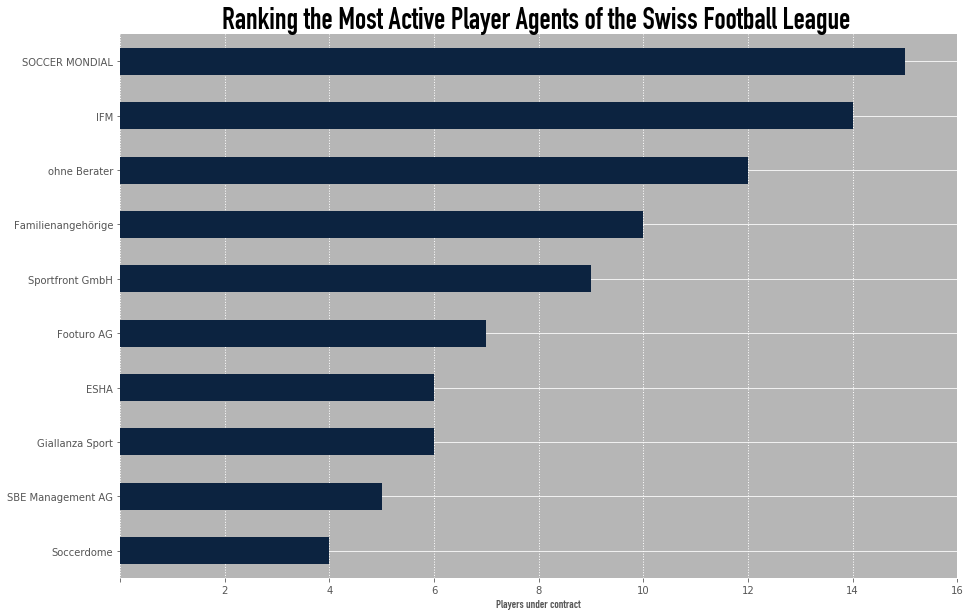

In [417]:
fig, ax = plt.subplots(figsize =(15,10))

#Font
csfont = {'fontname':'DIN Condensed'}

df_SL_transfers['Agent'].value_counts().head(10).sort_values(ascending=True).plot(kind='barh', color= "#0C2340")

ax.set_facecolor("#B6B6B6")

ax.xaxis.grid(color='white', linestyle=':', linewidth=1)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tick_params(
    #axis='x',
    top=False,
    which=False,
    left=False,
    right=False,
    bottom=False,
    labeltop=False,
    labelbottom=False)

#Labels and title
ax.set_xlabel('Players under contract', **csfont, fontsize=12)
ax.set_title("Ranking the Most Active Player Agents of the Swiss Football League ", **csfont, fontsize=30)

ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax.set_xticklabels(["", 2, 4, 6, 8, 10, 12, 14, 16])




#Saving
plt.savefig('Agents.pdf', transparent=True, bbox_inches='tight')
plt.savefig('Agents.png', transparent=True, bbox_inches='tight')

0
Rectangle(xy=(0, -0.25), width=4, height=0.5, angle=0)
1
Rectangle(xy=(0, 0.75), width=5, height=0.5, angle=0)
2
Rectangle(xy=(0, 1.75), width=6, height=0.5, angle=0)
3
Rectangle(xy=(0, 2.75), width=6, height=0.5, angle=0)
4
Rectangle(xy=(0, 3.75), width=7, height=0.5, angle=0)
5
Rectangle(xy=(0, 4.75), width=9, height=0.5, angle=0)
6
Rectangle(xy=(0, 5.75), width=10, height=0.5, angle=0)
7
Rectangle(xy=(0, 6.75), width=12, height=0.5, angle=0)
8
Rectangle(xy=(0, 7.75), width=14, height=0.5, angle=0)
9
Rectangle(xy=(0, 8.75), width=15, height=0.5, angle=0)


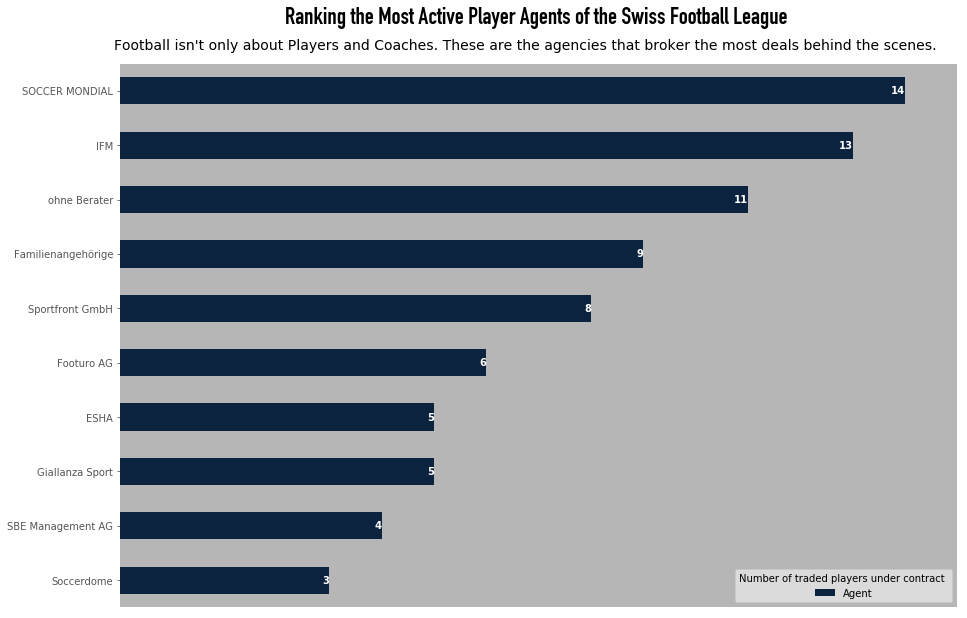

In [419]:
fig, ax = plt.subplots(figsize =(15,10))

#Font
csfont = {'fontname':'DIN Condensed'}

df_SL_transfers['Agent'].value_counts().head(10).sort_values(ascending=True).plot(kind='barh', color= "#0C2340")

ax.set_facecolor("#B6B6B6")

ax.xaxis.grid(color='white', linestyle=':', linewidth=1)


ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tick_params(
    #axis='x',
    top=False,
    which=False,
    left=False,
    right=False,
    bottom=False,
    labeltop=False,
    labelbottom=False)

#Labels and title and subtitle
#ax.set_xlabel('Traded players under contract', **csfont, fontsize=12)
ax.set_title("Ranking the Most Active Player Agents of the Swiss Football League ", **csfont, pad=40, fontsize=24)

plt.gcf().text(0.5, 0.9, "Football isn't only about Players and Coaches. These are the agencies that broker the most deals behind the scenes.", ha="center", fontsize=14)

ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax.set_xticklabels(["", 2, 4, 6, 8, 10, 12, 14, 16])

# xticks & yticks have empty lists to reduce white space in plot
ax.grid(False)
plt.xticks([])
#plt.yticks([])
#plt.tight_layout()

#Bars free:
for i, bar in enumerate(ax.patches):
    print(i)
    print(bar)
    
    #Now numbers inside of bars
    value = bar.get_width() -1
    x_pos = bar.get_width()
    y_pos = i
    ax.text(x_pos, y_pos, round(value,1), va='center', ha = "right", color="white", fontweight="bold")
    
#Legend   
ax.legend(loc='lower right', title='Number of traded players under contract ')


#Saving
plt.savefig('Agents_bars_free.pdf', transparent=True, bbox_inches='tight')
plt.savefig('Agents_bars_free.png', transparent=True, bbox_inches='tight')

In [428]:
##Safing the dataframe in a new one and making the club name also the Index, useful when making the graphs
df_bilanz_new = df_bilanz
df_bilanz_new.head(1)

,verein,total_marktwert_zuzuege,total_marktwert_abgaenge,differenz_marktwert,total_tore_zuzuege,total_tore_abgaenge,tore_differenz,total_vorlagen_zuzuege,total_vorlagen_abgaenge,vorlagen-differenz,total_spiele_zuzuege,total_spiele_abgaenge,total-spiel-differenz
0,BSC Young Boys,63500000.0,70750000.0,-7250000.0,234,380,-146,119,257,-138,1283,2432,-1149


In [429]:
df_bilanz_new.index = df_bilanz_new['verein']

### Differenz der Spielermarktwerte 

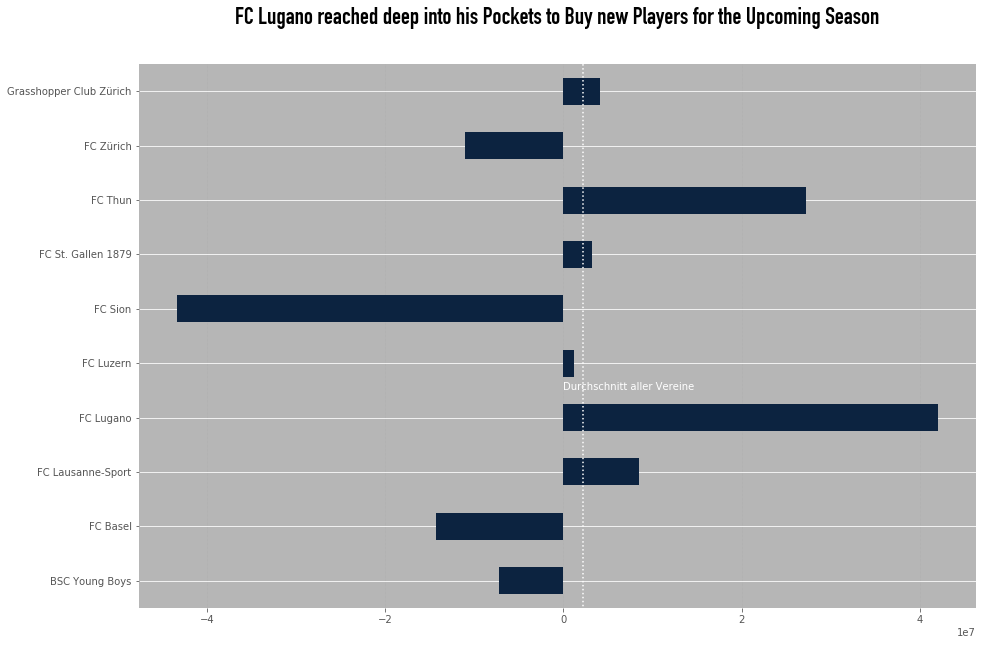

In [455]:
fig, ax = plt.subplots(figsize =(15,10))

#Font
csfont = {'fontname':'DIN Condensed'}

df_bilanz_new['differenz_marktwert'].plot(kind='barh', ax = ax, legend=False, color=['#0C2340'])
plt.axes

ax.set_facecolor("#B6B6B6")

ax.set_ylabel('')

ax.xaxis.grid(color='darkgrey', linestyle=':', linewidth=0.5)

#ax.set_xticks([-400000, -300000, -200000, -100000, 0, 100000, 200000, 300000, 400000])
#ax.set_xticklabels(["", 2, 4, 6, 8, 10, 12, 14, 16])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#plt.tick_params(
#    #axis='x',
#    top='off',
#    which='off',
#    left='off',
#    right='off',
#    bottom='off',
#    labeltop='off',
#    labelbottom='off')

#Labels and title
ax.set_title("FC Lugano reached deep into his Pockets to Buy new Players for the Upcoming Season", **csfont, pad=40, fontsize=24)

#Showing Median
median = df_bilanz_new['differenz_marktwert'].median()
ax.plot([median, median], [-4, 10], c='white', linestyle=':')
ax.annotate(s='Durchschnitt aller Vereine', xy=(4000,3.5), color='white')

ax.set_axisbelow(True)
plt.savefig('Marktwerte.pdf', transparent=True, bbox_inches='tight')
plt.savefig('Marktwerte.png', transparent=True, bbox_inches='tight')